# Reddit Scrape of Crypto Threads

### Import necessary modules and functions

In [ ]:
import pandas as pd           
import praw                   
import re                     
import requests               
import datetime as dt
import plotly
import cufflinks as cf
cf.go_offline()
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Build the thread scrap using PRAW and save to a DataFrame.  You will need to create a Reddit API
* This example is pulling last 500 New threads

### Generate a DataFrame of all potential crypto tickers
### Word scrape DF will be merged with crypto ticker DF to drop all non-crypto ticker words
### Generate desired plots
* In this example a bar graph illustrates frequency of each ticker over the last 500 threads
* In addition, a time series illustrates scrape trends for a list of key crypto tickers.  Currently set for 30 Days.  Can be automated by generating task in Windows Task Scheduler


In [2]:
# Use of Python Reddit API Wrapper (PRAW) to pull necessary information
reddit = praw.Reddit(client_id = 'XXX', client_secret = 'XXX', # add your API details
                     user_agent = 'XXX', username = 'XXX', password = 'XXXX') # add your user agent, user name, and password

# Iterate through CryproCurrency posts filtered to New to compile a DataFrame of post title & post text
df = []
for post in reddit.subreddit('CryptoCurrency').new(limit=500):
  content = {"title" : post.title, "text" : post.selftext}
  df.append(content)
df = pd.DataFrame(df)

# Iterate through DataFrame to count word instances and combine to dictionary which is then converted to a DataFrame
# Special thanks to @tom.santinelli and his post on Medium for this part of the code
#https://medium.com/@tom.santinelli/scraping-reddits-wall-street-bets-for-popular-stock-tickers-38ed5202affc
regex = re.compile('[^a-zA-Z ]')
word_dict = {}
for (index, row) in df.iterrows():
  # titles
  title = row['title']
  title = regex.sub('', title)
  title_words = title.split(' ')
  # content
  content = row['text']
  content = regex.sub('', content)
  content_words = content.split(' ')
  # combine
  words = title_words + content_words
  for x in words:
    if x in ['HODL']:
        pass
    elif x in word_dict:
      word_dict[x] += 1
    else:
      word_dict[x] = 1
word_df = pd.DataFrame.from_dict(list(word_dict.items())).rename(columns = {0:"Term", 1:"Frequency"})

# Generate a CSV of all possible CryptoCurrency tickers
ticker_df = pd.read_csv('XXX').rename(columns = {"Symbol":"Term", "Name":"Company_Name"}) # create CSV file to save info

# Merge the Crpyto Ticker DataFrame with the word DataFrame from Reddit
crypto_df = pd.merge(ticker_df, word_df, on="Term")

# Compile DataFrame of top 10 CryptoCurrencys from the day and save as CSV for use 
top10_df = crypto_df.sort_values("Frequency", ascending=False).head(10)
crypto_df.to_csv('XXX', index=False) # save CSV of info


# Will now generate a DataFrame to capture daily frequency data for key crypto tickers and append to CSV for timeseries plot
keys = ['BTC','ETH','MATIC','ADA','LINK']
keys_df = crypto_df.loc[crypto_df['Term'].isin(keys)]

keys_df = keys_df.set_index('Term').drop('Company_Name', axis = 1)
keys_df_T = keys_df.T.reset_index().drop('index', axis = 1)
keys_df_T['Date'] = dt.datetime.now().strftime('%m/%d/%Y')

keys_df_T.to_csv('XXX', mode = 'a', header = False, index = False) # Generate CSV to save info

daily_df = pd.read_csv('') # read file that contains info for time series crypto data.  In this example the program is run daily using Windows Task Scheduler
daily_df = daily_df.drop_duplicates(subset = ['Date'], keep = 'first').iloc[-30:]

# Generate two plots: 1) a bar plot illustrating frequnecy of ticker use in thread and 2) a plot illustrating last 30 days of frequency (limited to keys tickers)
top10_df.iplot(kind = 'bar', x = 'Term', y = 'Frequency', xTitle = 'Crypto Ticker', yTitle = 'Daily Frequency', title = "Top 10 CryptoCurrencys Mentioned Today on Reddit's CryptoCurrency Thread")
daily_df.iplot(kind = 'scatter', x = 'Date', xTitle = 'Date', yTitle = 'Daily Frequency', title = "Daily Count of Key CryptoCurrencys Mentioned on Reddit Thread", symbol = 'circle', mode = 'lines+markers')

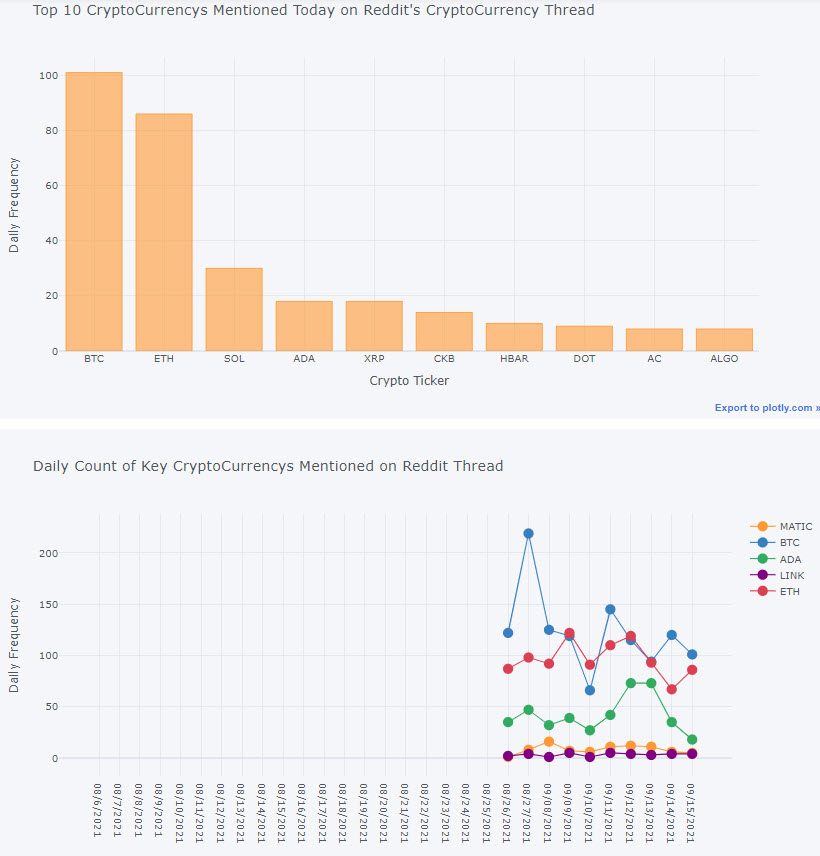